# Import des modules

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
sns.set(color_codes=True)
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.tree.export import export_text
import graphviz 
from sklearn import tree
from sklearn.metrics import roc_curve
from sklearn.svm import SVC
import sqlite3
import warnings
warnings.filterwarnings('ignore')

# Import geoxilia base and display some basic results

In [ ]:
# get files from drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
# import geoxilia database
geoxilia_clean=pd.read_csv('/content/gdrive/My Drive/geoxilia_clean_V2.csv')

In [ ]:
list_columns=list(geoxilia_clean.columns)
list_columns

['Unnamed: 0',
 'DEPTH',
 'GR',
 'CAL',
 'DCOR',
 'DENS',
 'DTC',
 'DTS',
 'PE',
 'PHIN',
 'RESD',
 'RESM',
 'RESS',
 'RESMIC',
 'SP',
 'DEPTH_M',
 'WELL',
 'LITHO']

In [ ]:
print('There is {} observations and {} columns in the table geoxilia_brut which contains only data labeled'.format(geoxilia_clean.shape[0],geoxilia_clean.shape[1]))

There is 260584 observations and 18 columns in the table geoxilia_brut which contains only data labeled


In [ ]:
# display the top 5 rows
geoxilia_clean.head()

,Unnamed: 0,DEPTH,GR,CAL,DCOR,DENS,DTC,DTS,PE,PHIN,RESD,RESM,RESS,RESMIC,SP,DEPTH_M,WELL,LITHO
0,0,2848.0,30.1875,NaN,NaN,NaN,116.0000,-9999.0,-9999.0,0.0,3.6055,3.5996,-9999.0,-9999.0,-44.6875,868.0704,11/30A-A17,LCSD
1,1,2848.5,21.8125,NaN,NaN,NaN,117.3750,-9999.0,-9999.0,0.0,3.6602,3.2617,-9999.0,-9999.0,-42.9063,868.2228,11/30A-A17,LCSD
2,2,2849.0,21.8750,NaN,NaN,NaN,118.1875,-9999.0,-9999.0,0.0,3.6719,3.2266,-9999.0,-9999.0,-41.6875,868.3752,11/30A-A17,LCSD
3,3,2849.5,17.1875,NaN,NaN,NaN,114.5625,-9999.0,-9999.0,0.0,3.7285,3.1621,-9999.0,-9999.0,-40.9688,868.5276,11/30A-A17,LCSD
4,4,2850.0,17.9375,NaN,NaN,NaN,112.5625,-9999.0,-9999.0,0.0,3.5488,3.2422,-9999.0,-9999.0,-39.7188,868.6800,11/30A-A17,LCSD


In [ ]:
# To display the bottom 5 rows
geoxilia_clean.tail()

,Unnamed: 0,DEPTH,GR,CAL,DCOR,DENS,DTC,DTS,PE,PHIN,RESD,RESM,RESS,RESMIC,SP,DEPTH_M,WELL,LITHO
260579,260579,12130.0,NaN,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,3697.2240,11/30A-A27,HISD
260580,260580,12130.5,NaN,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,3697.3764,11/30A-A27,HISD
260581,260581,12131.0,NaN,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,3697.5288,11/30A-A27,HISD
260582,260582,12131.5,NaN,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,3697.6812,11/30A-A27,HISD
260583,260583,12132.0,NaN,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,0.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,3697.8336,11/30A-A27,HISD


In [ ]:
# Categorical columns: juste 42 puits distincts et 62 litho distincts dans les données labellisées 
geoxilia_clean.describe(include=['object', 'bool']) 

,WELL,LITHO
count,260584,260584
unique,42,62
top,13/30-3,OXSH
freq,19811,48531


# **Commentaire:**

Dans notre base nous avons 260584 obesrvations auxquelles des lithologies ont été associées. Nous avons 42 puits distincts dans nos données labellisée et 62 lithologies distinctes
Les premiers aperçus ci-haut montrent qu'il y a des valeurs NaN (ou manquantes) pour certaines variables. 
Les valeurs -9999.0 et 0.0 correspondent à des variables absentes selon les puits concernés (Par exemple ci-haut pour le puits 11/30A-A27 toutes les variables importantes sont absentes ). En efffet quand on ouvre le fichier data.las de ce puits on se rend compte que seule la variable Gamma Ray est disponible (voir 11_30a-A27_jwl_JWL_FILE_1683359.las)
Donc les données présentent deux anomalies:
des variables importantes absentes dans certains puits (codées -9999.0 et 0.0) et des données manquantes (codées NaN). 
Pour faciliter la compréhension toutes les valeurs des variables absentes  (i.e avec -9999.0 et 0.0) seront qualifiées d' **"indisponibles"** et celles avec NaN de **"manquantes"**
Maintenant que ces anomalies sont détectées nous allons les quantifier pour chaque variable et nettoyer la base pour avoir une base propre sur laquelle nous ferons notre analyse exploratoire.

# **Cleaning**


## Cleaning -9999.0 and 0.0 values

In [ ]:
# Check feature with values equal -9999.0 and 0.0
logs_=[]
nb_val_manq=[]
nb_puits_impact=[]
pourc_val_manq=[]
for i in geoxilia_clean.columns:
  test=geoxilia_clean[geoxilia_clean[str(i)]==-9999]
  if test.shape[0]>0:
    logs_.append(i)
    nb_val_manq.append(test.shape[0])
    pourc_val_manq.append(test.shape[0]/geoxilia_clean.shape[0])
    nb_puits_impact.append(test['WELL'].unique().shape[0])
    print(str(i),'est manquante dans ',test['WELL'].unique().shape[0],'puits et cela correspond à',test.shape[0],'observations soit',test.shape[0]/geoxilia_clean.shape[0],'des données')
for i in list_columns:
  if i not in logs_:
    print('la variable',i,'est présente dans tous les puits')

nb_puit_glob=geoxilia_clean['WELL'].unique().shape[0]
list_nb_glob_puits=[nb_puit_glob for i in range(len(logs_))]
percent_puits_impact=[nb_puits_impact[i]/geoxilia_clean['WELL'].unique().shape[0] for i in range(len(nb_puits_impact))]
dict_={'Log_':logs_,'nb_val_manquante':nb_val_manq,'nb_puits_impact':nb_puits_impact,'percent_val_manq':pourc_val_manq,'nb_glob_puits':list_nb_glob_puits,'percent_puits_impact':percent_puits_impact}
Synth_feat_manq=pd.DataFrame(dict_)

Synth_feat_manq

CAL est manquante dans  6 puits et cela correspond à 15744 observations soit 0.06041813772142572 des données
DCOR est manquante dans  7 puits et cela correspond à 15845 observations soit 0.060805728670985174 des données
DENS est manquante dans  4 puits et cela correspond à 5753 observations soit 0.022077333988272496 des données
DTC est manquante dans  11 puits et cela correspond à 29184 observations soit 0.11199459675191109 des données
DTS est manquante dans  42 puits et cela correspond à 260584 observations soit 1.0 des données
PE est manquante dans  32 puits et cela correspond à 182737 observations soit 0.7012594787093606 des données
PHIN est manquante dans  3 puits et cela correspond à 4380 observations soit 0.01680839959475639 des données
RESD est manquante dans  3 puits et cela correspond à 3089 observations soit 0.011854143001872717 des données
RESM est manquante dans  5 puits et cela correspond à 14396 observations soit 0.055245141681760965 des données
RESS est manquante dans  2

,Log_,nb_val_manquante,nb_puits_impact,percent_val_manq,nb_glob_puits,percent_puits_impact
0,CAL,15744,6,0.060418,42,0.142857
1,DCOR,15845,7,0.060806,42,0.166667
2,DENS,5753,4,0.022077,42,0.095238
3,DTC,29184,11,0.111995,42,0.261905
4,DTS,260584,42,1.000000,42,1.000000
5,PE,182737,32,0.701259,42,0.761905
6,PHIN,4380,3,0.016808,42,0.071429
7,RESD,3089,3,0.011854,42,0.071429
8,RESM,14396,5,0.055245,42,0.119048
9,RESS,182482,29,0.700281,42,0.690476


Text(0.5, 1.0, 'Pourcentage de puits impactés par les variables manquantes')

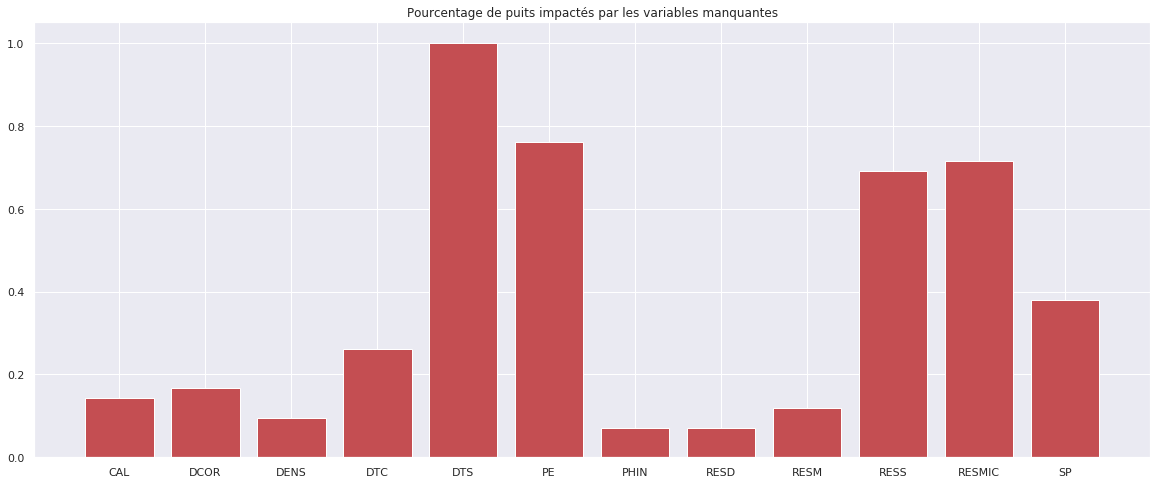

In [ ]:
plt.figure(figsize=(20,8))
#plt.subplot()
#plt.bar(Synth_feat_manq['Log_'],height=Synth_feat_manq['percent_val_manq'])
plt.bar(Synth_feat_manq['Log_'],height=Synth_feat_manq['percent_puits_impact'],color='r')
plt.title('Pourcentage de puits impactés par les variables manquantes')

## **Commentaire :**

Seule la variable Gamma Ray est présente dans tous les puits
Les variables DTS,PE,RESS,RESMIC sont absentes dans plus de 70% des puits.
Hormi la variable Photo Electric (PE) qui fait partie des variables importantes listées par Geoxilia les autres  variables seront supprimées pour éviter les erreurs de généralisation du modélé . 
Pour les autres variables moins impactées nous supprimerons juste les observations concernées (ie observations avec valeurs indisponibles)
Afin d'avoir un base de données avec beaucoup d'observation d'une part et de tenir compte de l'importance de la variable "PE" nous construirons deux bases: geoxilia_clean_var (base initiale sans les variables DTS,PE,RESS,RESMIC) et geoxilia_clean_var1 (base initiale avec PE mais sans DTS,RESS,RESMIC)

In [ ]:
# drop DTS,RESS,RESMIC 

geoxilia_clean_var=geoxilia_clean[['GR','CAL','DCOR','DENS','DTC','PHIN','RESD','RESM','SP','DEPTH','WELL','LITHO']] # sans PE
geoxilia_clean_var1=geoxilia_clean[['GR','CAL','DCOR','DENS','DTC','PHIN','PE','RESD','RESM','SP','DEPTH','WELL','LITHO']] # sans PE
# Drop -9999 and 0.0
def delete_anomal(table):
  for i in list(table.columns):
    # Get names of indexes for which column contains value -9999
    indexNames =table[table[i] == -9999.0].index
    indexNames1 =table[table[i] == 0.0 ].index
    # Delete these row indexes from training
    table.drop(indexNames , inplace=True)
    table.drop(indexNames1 , inplace=True)
    #return table.drop(indexNames , inplace=True).drop(indexNames1 , inplace=True)


In [ ]:
delete_anomal(geoxilia_clean_var)
delete_anomal(geoxilia_clean_var1)

In [ ]:
# check if -9999.0 and 0.0 are really dropped
verif=geoxilia_clean_var[geoxilia_clean_var['CAL'] == -9999.0]
verif

,GR,CAL,DCOR,DENS,DTC,PHIN,RESD,RESM,SP,DEPTH,WELL,LITHO


In [ ]:
verif=geoxilia_clean_var1[geoxilia_clean_var1['PE'] == -9999.0]
verif

,GR,CAL,DCOR,DENS,DTC,PHIN,PE,RESD,RESM,SP,DEPTH,WELL,LITHO


In [ ]:
print('il reste ',geoxilia_clean_var.shape[0],'obervations après suppression des valeurs indisponibles soit ',geoxilia_clean_var.shape[0]/geoxilia_clean.shape[0],'des données initiales')
print('il reste ',geoxilia_clean_var1.shape[0],'obervations après suppression des valeurs indisponibles soit ',geoxilia_clean_var1.shape[0]/geoxilia_clean.shape[0],'des données initiales')

il reste  78785 obervations après suppression des valeurs indisponibles soit  0.30234012832714213 des données initiales
il reste  38289 obervations après suppression des valeurs indisponibles soit  0.1469353452245725 des données initiales


### Cleaning NaN values

In [ ]:
# Checking NaN data- Many Important features DTC,RESD,RESM, and SP  have a lot of NaN values
NaN_val=geoxilia_clean_var.isna().sum()
NaN_val

GR         613
CAL       2474
DCOR      2844
DENS      2773
DTC      20959
PHIN         0
RESD     12609
RESM     16060
SP       21565
DEPTH        0
WELL         0
LITHO        0
dtype: int64

In [ ]:
NaN_val1=geoxilia_clean_var1.isna().sum()
NaN_val1

GR         499
CAL       2268
DCOR      2707
DENS      2706
DTC      20530
PHIN         0
PE        2707
RESD      3239
RESM      3240
SP       17295
DEPTH        0
WELL         0
LITHO        0
dtype: int64

Text(0.5, 1.0, 'geoxilia_clean_var: Pourcentage de valeurs bien renseignées par variable')

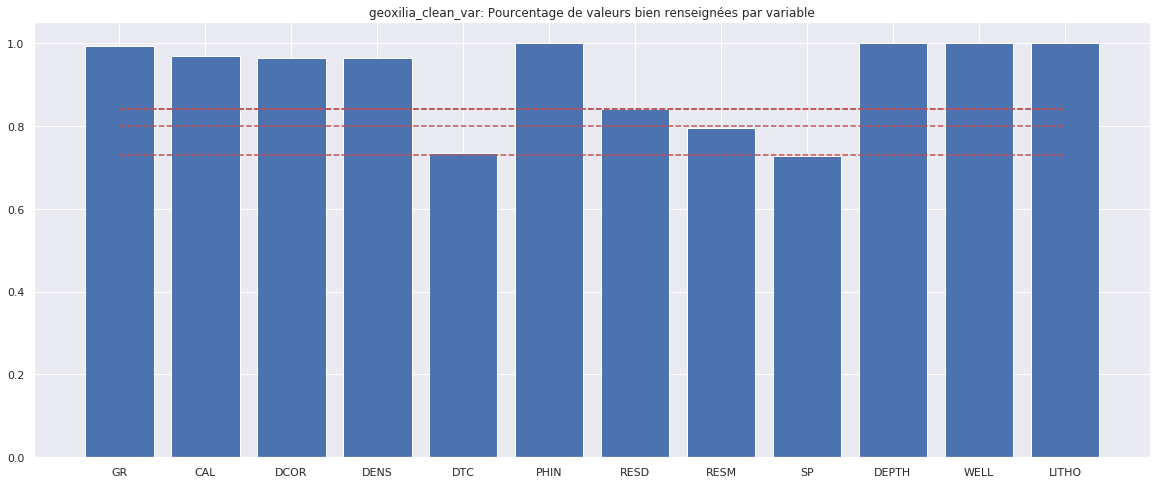

In [ ]:
# Percentage NaN values for each feature
var=list(NaN_val.keys())
Nbre_NaN=[]
Resume_NaN=np.zeros((len(var),2))
for i in NaN_val.keys():
  Nbre_NaN.append(NaN_val[i]/geoxilia_clean_var.shape[0])
Resume_NaN=pd.DataFrame(Resume_NaN)
Resume_NaN['features']=var
Resume_NaN['pourc_NaN']=Nbre_NaN
Resume_NaN=Resume_NaN[['features','pourc_NaN']]
horiz_line_data1=[0.84 for i in range(geoxilia_clean_var.shape[1])]
horiz_line_data2=[0.84 for i in range(geoxilia_clean_var.shape[1])]
horiz_line_data3=[0.80 for i in range(geoxilia_clean_var.shape[1])]
horiz_line_data4=[0.73 for i in range(geoxilia_clean_var.shape[1])]
plt.figure(figsize=(20,8))
plt.subplot()
plt.bar(Resume_NaN['features'],height=(1-Resume_NaN['pourc_NaN']))
plt.plot(Resume_NaN['features'], horiz_line_data1, 'r--')
plt.plot(Resume_NaN['features'], horiz_line_data2, 'r--')
plt.plot(Resume_NaN['features'], horiz_line_data3, 'r--')
plt.plot(Resume_NaN['features'], horiz_line_data4, 'r--')
plt.title('geoxilia_clean_var: Pourcentage de valeurs bien renseignées par variable')


Text(0.5, 1.0, 'geoxilia_clean_var1: Pourcentage de valeurs bien renseignées par variable')

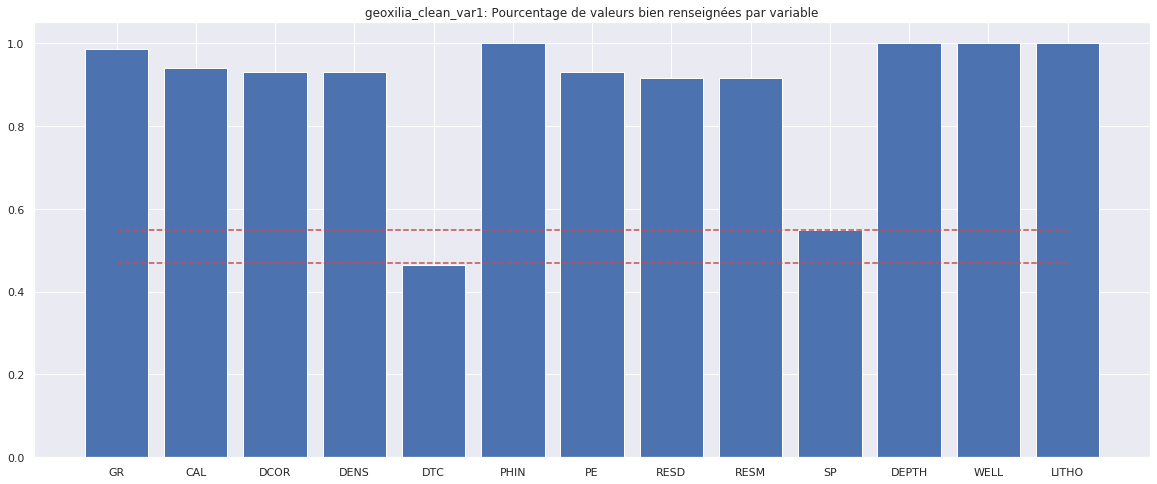

In [ ]:
var=list(NaN_val1.keys())
Nbre_NaN=[]
Resume_NaN=np.zeros((len(var),2))
for i in NaN_val1.keys():
  Nbre_NaN.append(NaN_val1[i]/geoxilia_clean_var1.shape[0])
Resume_NaN=pd.DataFrame(Resume_NaN)
Resume_NaN['features']=var
Resume_NaN['pourc_NaN']=Nbre_NaN
Resume_NaN=Resume_NaN[['features','pourc_NaN']]
horiz_line_data1=[0.47 for i in range(geoxilia_clean_var1.shape[1])]
horiz_line_data2=[0.55 for i in range(geoxilia_clean_var1.shape[1])]
plt.figure(figsize=(20,8))
plt.subplot()
plt.bar(Resume_NaN['features'],height=(1-Resume_NaN['pourc_NaN']))
plt.plot(Resume_NaN['features'], horiz_line_data1, 'r--')
plt.plot(Resume_NaN['features'], horiz_line_data2, 'r--')
plt.title('geoxilia_clean_var1: Pourcentage de valeurs bien renseignées par variable')

# **Commentaire :**

### Geoxilia_clean_var:
 Nous constatons que le nombre de valeurs manquantes varie fortement selon les variables considérées. Par exemple la variable DENS a plus de 50% de valeurs NaN et la variable GR en a moins de 5%. Ainsi avoir une table toutes les variables sans valeurs manquantes revient à conserver que 50% des données initiales. D'où la nécessité de construire plusieurs datasets avec des thresholds de valeurs non manquantes.

Ainsi dans la suite nous allons supprimer ces valeurs manquantes (un algorithme d'imputation des données sera utilisé dans les prochaines étapes de la phase 2 du projet pour remplacer ces NaN). DOnc le nombre d'observations après suppression des valeurs manquantes dépend des variables sélectionnées. Ainsi afin d'avoir un nombre :

*   df1: geoxilia_clean_var sans NaN (on supprime tous les NaN de geoxilia_clean_var)
*   df2: geoxilia_clean_var sans SP et DTC (variables présentant chacune 27% de données NaN) et sans NaN
*   df3: geoxilia_clean_var sans SP ,DTC et RESM et sans NaN 

### Geoxilia_clean_var1:
Mêême analyse que celle ci-haut. NOus décidons de créer 3 tables

*   df4: geoxilia_clean_var1 sans NaN (on supprime tous les NaN de geoxilia_clean_var)
*   df5: geoxilia_clean_var1 sans SP et DTC (variables présentant resp. 43%  et 55% de données NaN) et sans NaN




In [ ]:
## Create table without NaN values
df1=geoxilia_clean_var[['GR','CAL','DCOR','DENS','DTC','PHIN','RESD','RESM','SP','DEPTH','WELL','LITHO']]
df2=geoxilia_clean_var[['GR','CAL','DCOR','DENS','PHIN','RESD','RESM','DEPTH','WELL','LITHO']]
df3=geoxilia_clean_var[['GR','CAL','DCOR','DENS','PHIN','RESD','DEPTH','WELL','LITHO']]
df4=geoxilia_clean_var1[['GR','CAL','DCOR','DENS','DTC','PE','PHIN','RESD','RESM','SP','DEPTH','WELL','LITHO']]
df5=geoxilia_clean_var1[['GR','CAL','DCOR','DENS','PE','PHIN','RESD','RESM','DEPTH','WELL','LITHO']]

list_table=[df1,df2,df3,df4,df5]
for i in list_table:
  i=i.dropna()
  print(i.isnull().sum())


GR       0
CAL      0
DCOR     0
DENS     0
DTC      0
PHIN     0
RESD     0
RESM     0
SP       0
DEPTH    0
WELL     0
LITHO    0
dtype: int64
GR       0
CAL      0
DCOR     0
DENS     0
PHIN     0
RESD     0
RESM     0
DEPTH    0
WELL     0
LITHO    0
dtype: int64
GR       0
CAL      0
DCOR     0
DENS     0
PHIN     0
RESD     0
DEPTH    0
WELL     0
LITHO    0
dtype: int64
GR       0
CAL      0
DCOR     0
DENS     0
DTC      0
PE       0
PHIN     0
RESD     0
RESM     0
SP       0
DEPTH    0
WELL     0
LITHO    0
dtype: int64
GR       0
CAL      0
DCOR     0
DENS     0
PE       0
PHIN     0
RESD     0
RESM     0
DEPTH    0
WELL     0
LITHO    0
dtype: int64


In [ ]:
list_table=['df1','df2','df3','df4','df5']
val_=[df1.dropna().shape[0],df2.dropna().shape[0],df3.dropna().shape[0],df4.dropna().shape[0],df5.dropna().shape[0]]
dim_ini1=[geoxilia_clean_var.shape[0] for i in range(3)]
dim_ini2=[geoxilia_clean_var1.shape[0] for i in range(2)]
dim_ini=dim_ini1+dim_ini2
synth_NaN=np.zeros((5,2))
synth_NaN=pd.DataFrame(synth_NaN)
synth_NaN['dataset_name']=list_table
synth_NaN['Dimension']=val_
synth_NaN['Dim_initial']=dim_ini
synth_NaN['Number_NaN_deleted']=synth_NaN['Dim_initial']-synth_NaN['Dimension']
synth_NaN=synth_NaN[['dataset_name','Dimension','Dim_initial','Number_NaN_deleted']]
synth_NaN

,dataset_name,Dimension,Dim_initial,Number_NaN_deleted
0,df1,43510,78785,35275
1,df2,61363,78785,17422
2,df3,65859,78785,12926
3,df4,17212,38289,21077
4,df5,34967,38289,3322


In [ ]:
df1=df1.dropna()
df2=df2.dropna()
df3=df3.dropna()
df4=df4.dropna()
df5=df5.dropna()

In [ ]:
# geoxilia_clean_var: 79K observations ,22 puits distincts et 37 litho distinctes dans les données labellisées après suppression 
#des variables absentes dans plus de 70% des puits des données initiales
geoxilia_clean_var.describe(include=['object', 'bool']) 

,WELL,LITHO
count,78785,78785
unique,22,37
top,13/30-3,BCOL
freq,14774,13495


In [ ]:
# geoxilia_clean_var: 38K observations ,7 puits distincts et 27 litho distinctes dans les données labellisées après suppression 
#des variables absentes dans plus de 70% des puits des données initiales
geoxilia_clean_var1.describe(include=['object', 'bool']) 

,WELL,LITHO
count,38289,38289
unique,7,27
top,13/30-3,KIMM
freq,14774,6196


In [ ]:
# df1: 43K observations ,19 puits distincts et 17 litho distincts 
df1.describe(include=['object', 'bool']) 

,WELL,LITHO
count,43510,43510
unique,19,17
top,11/30A-B2,BCOL
freq,5164,11417


In [ ]:
# df2: 61K observations ,21 puits distincts et 32 litho distincts 
df2.describe(include=['object', 'bool']) 

,WELL,LITHO
count,61363,61363
unique,21,32
top,13/30-3,BCOL
freq,14732,12454


In [ ]:
# df3: 66K observations ,22 puits distincts et 33 litho distincts
df3.describe(include=['object', 'bool']) 

,WELL,LITHO
count,65859,65859
unique,22,33
top,13/30-3,BCOL
freq,14732,13415


In [ ]:
# df4: 17K observations ,5 puits distincts et 11 litho distinctes
df4.describe(include=['object', 'bool']) 

,WELL,LITHO
count,17212,17212
unique,5,11
top,11/30A-A26,BCOL
freq,4968,4496


In [ ]:
# df5: 35K observations ,7 puits distincts et 26 litho distinctes
df5.describe(include=['object', 'bool']) 

,WELL,LITHO
count,34967,34967
unique,7,26
top,13/30-3,KIMM
freq,14732,6196


# **Traitement des lithologies dynamiques**
Les lithologies dynamiques sont des lithologies qui évoluent selon leur ââge. A un moment t ils peuvent etre "argile" et à un autre moment t+dt "non argile". Ces types de lithologie seront supprimés parce que leur classification est juste valablepour un moment t donné.

In [ ]:
list_LITHO_1=list(df1['LITHO'].unique())
list_LITHO_2=list(df2['LITHO'].unique())
list_LITHO_3=list(df3['LITHO'].unique())
list_LITHO_4=list(df4['LITHO'].unique())
list_LITHO_5=list(df5['LITHO'].unique())
list_LITHO=list_LITHO_1+list_LITHO_2+list_LITHO_3

In [ ]:
print('il y a ',len(list(set(list_LITHO))),' lithologies distinctes dans les 5 bases')

il y a  33  lithologies distinctes dans les 5 bases


In [ ]:
list_litho=list(set(list_LITHO))
list_litho_prob=['LI','TRIG','ROTL','DEVG','MORY','MAUR','DEVH','PIPE','SELE']
j=0
list_prob=[]
for i in list_litho:
    if i in list_litho_prob:
        list_prob.append(i)        
        j=j+1
print('il y a ',j,'litho dynamiques avec le temps et présentes dans nos 3 bases qui sont: ',list_prob)

il y a  3 litho dynamiques avec le temps et présentes dans nos 3 bases qui sont:  ['LI', 'DEVH', 'PIPE']


In [ ]:
for i in list_prob:
    print('Il y a ',len(df1[df1['LITHO']==str(i)]),'observations dans la table df1 pour lesquelles la litholgie dynamique est ',i)

Il y a  1652 observations dans la table df1 pour lesquelles la litholgie dynamique est  LI
Il y a  0 observations dans la table df1 pour lesquelles la litholgie dynamique est  DEVH
Il y a  0 observations dans la table df1 pour lesquelles la litholgie dynamique est  PIPE


In [ ]:
for i in list_prob:
    print('Il y a ',len(df2[df2['LITHO']==str(i)]),'observations dans la table df2 pour lesquelles la litholgie dynamique est ',i)

Il y a  1652 observations dans la table df2 pour lesquelles la litholgie dynamique est  LI
Il y a  1563 observations dans la table df2 pour lesquelles la litholgie dynamique est  DEVH
Il y a  452 observations dans la table df2 pour lesquelles la litholgie dynamique est  PIPE


In [ ]:
for i in list_prob:
    print('Il y a ',len(df3[df3['LITHO']==str(i)]),'observations dans la table df3 pour lesquelles la litholgie dynamique est ',i)

Il y a  1654 observations dans la table df3 pour lesquelles la litholgie dynamique est  LI
Il y a  1563 observations dans la table df3 pour lesquelles la litholgie dynamique est  DEVH
Il y a  452 observations dans la table df3 pour lesquelles la litholgie dynamique est  PIPE


In [ ]:
for i in list_prob:
    print('Il y a ',len(df4[df4['LITHO']==str(i)]),'observations dans la table df4 pour lesquelles la litholgie dynamique est ',i)

Il y a  0 observations dans la table df4 pour lesquelles la litholgie dynamique est  LI
Il y a  0 observations dans la table df4 pour lesquelles la litholgie dynamique est  DEVH
Il y a  0 observations dans la table df4 pour lesquelles la litholgie dynamique est  PIPE


In [ ]:
for i in list_prob:
    print('Il y a ',len(df5[df5['LITHO']==str(i)]),'observations dans la table df5 pour lesquelles la litholgie dynamique est ',i)

Il y a  0 observations dans la table df5 pour lesquelles la litholgie dynamique est  LI
Il y a  1563 observations dans la table df5 pour lesquelles la litholgie dynamique est  DEVH
Il y a  452 observations dans la table df5 pour lesquelles la litholgie dynamique est  PIPE


# Commentaire:
 
 Il y a 1,6k observations dans la table df1 pour lesquelles la lithologie est dynamique.
 Nous en avons 3,4k dans les 2 autres tables df2 et df3 et 2k dans df5
Ces lithologies étant appelées à évoluer avec le temps nous allons les supprimer 

## Supression des lithologies 'LI', 'PIPE', 'DEVH'

In [ ]:
list_table=[df1,df2,df3,df4,df5]
list_litho_=['LI', 'PIPE', 'DEVH']
for table in list_table:
    for j in list_litho_:
             # Get names of indexes for which column contains value -9999
            indexNames =table[table['LITHO'] == j ].index
            # Delete these row indexes from training
            table.drop(indexNames , inplace=True)

In [ ]:
print('Après suppression des lithologies dynamiques la table df1 contient: ',df1.shape[0],'observations' )
print('Après suppression des lithologies dynamiques la table df2 contient: ',df2.shape[0],'observations' )
print('Après suppression des lithologies dynamiques la table df3 contient: ',df3.shape[0],'observations' )
print('Après suppression des lithologies dynamiques la table df4 contient: ',df4.shape[0],'observations' )
print('Après suppression des lithologies dynamiques la table df5 contient: ',df5.shape[0],'observations' )

Après suppression des lithologies dynamiques la table df1 contient:  41858 observations
Après suppression des lithologies dynamiques la table df2 contient:  57696 observations
Après suppression des lithologies dynamiques la table df3 contient:  62190 observations
Après suppression des lithologies dynamiques la table df4 contient:  17212 observations
Après suppression des lithologies dynamiques la table df5 contient:  32952 observations


# Encodage de la variable LITHO:

Dans cette partie nous allons créer une variable LITHO_VF qui sera égale à 1 si la variable LITHO est argile et 0 sinon

In [ ]:
# Encodage de la variable LITHO en argile,non_argile
df1['LITHO_1']=df1['LITHO']
df1['LITHO_VF']=df1['LITHO']
df2['LITHO_1']=df2['LITHO']
df2['LITHO_VF']=df2['LITHO']
df3['LITHO_1']=df3['LITHO']
df3['LITHO_VF']=df3['LITHO']
df4['LITHO_1']=df4['LITHO']
df4['LITHO_VF']=df4['LITHO']
df5['LITHO_1']=df5['LITHO']
df5['LITHO_VF']=df5['LITHO']

dict_label1={"LITHO_1": {"LCSD":"non_argile","KIMM":"argile","RYSD":"non_argile","VOSD":"non_argile",
                        "BLAS":"argile","HISD":"non_argile","LAWS":"argile","JSAN":"non_argile","TRBS":"argile",
                        'CHER':"argile", 'MISH':"argile", 'VKSD':"non_argile",'HERR':"non_argile", 
                         'PLNM':"argile", 'HIDR':"non_argile", 'LCSG':"non_argile", 'KLSG':"argile", 'RZDM':"non_argile", 
                         'BEAA':"non_argile",'STCR':"argile", 'LHSM':"argile", 'OSPS':"non_argile", 'BEAB':"non_argile",
                         'TRIG':"non_argile", 'ZECH':"argile", 'ROTL':"non_argile", 'ROTC':"argile",'HORD':"non_argile", 
                         'BALD':"non_argile", 'MORY':"non_argile", 'MAUR':"non_argile", 'EKOF':"non_argile", 'TORF':"non_argile",
                         'FLND':"non_argile", 'RODB':"argile",'SOLA':"argile", 'ASGA':"non_argile", 'VALH':"argile", 
                         'HEAT':"argile", 'BSMT':"non_argile", 'OXSS':"argile",
                         'INOX':"argile", 'INTB':"non_argile", 'BCOH':"non_argile", 'BCOI':"non_argile", 'DUNJ':"non_argile",
                         'DURB':"argile", 'SLSH':"argile", 'BOCL':"argile",'TTSA':"non_argile", 'TUPS':"non_argile",
                         'TFOS':"non_argile", 'TMIS':"non_argile", 'TLTS':"non_argile", 'TLOS':"non_argile",
                         "ABSD":"non_argile","BCOL":"non_argile","OXSH":"argile","BOCL":"non_argile","BLSD":"non_argile"}
           }
dict_label2={"LITHO_VF":{"LCSD":"0","KIMM":"1","RYSD":"0","VOSD":"0",
                        "BLAS":"1","HISD":"0","LAWS":"1","JSAN":"0","TRBS":"1",
                        'CHER':"1", 'MISH':"1", 'VKSD':"0", 'HERR':"0", 
                         'PLNM':"1", 'HIDR':"0", 'LCSG':"0", 'KLSG':"1", 'RZDM':"0", 
                         'BEAA':"0",'STCR':"1", 'LHSM':"1", 'OSPS':"0", 'BEAB':"0",
                         'TRIG':"0", 'ZECH':"1", 'ROTL':"0", 'ROTC':"1",'HORD':"0", 
                         'BALD':"0", 'MORY':"0", 'MAUR':"0", 'EKOF':"0", 'TORF':"0",
                         'FLND':"0", 'RODB':"1",'SOLA':"1", 'ASGA':"0", 'VALH':"1", 
                          'HEAT':"1",'BSMT':"0", 'OXSS':"1",
                         'INOX':"1", 'INTB':"0", 'BCOH':"0", 'BCOI':"0", 'DUNJ':"0",
                         'DURB':"1", 'SLSH':"1", 'BOCL':"1",'TTSA':"0", 'TUPS':"0",
                         'TFOS':"0", 'TMIS':"0", 'TLTS':"0", 'TLOS':"0",
                         "ABSD":"0","BCOL":"0","OXSH":"1","BOCL":"0","BLSD":"1"}
            }


In [ ]:
df1.replace(dict_label1, inplace=True)
df1.replace(dict_label2, inplace=True)
df2.replace(dict_label1, inplace=True)
df2.replace(dict_label2, inplace=True)
df3.replace(dict_label1, inplace=True)
df3.replace(dict_label2, inplace=True)
df4.replace(dict_label1, inplace=True)
df4.replace(dict_label2, inplace=True)
df5.replace(dict_label1, inplace=True)
df5.replace(dict_label2, inplace=True)

In [ ]:
df1.head()

,GR,CAL,DCOR,DENS,DTC,PHIN,RESD,RESM,SP,DEPTH,WELL,LITHO,LITHO_1,LITHO_VF
22864,54.0,12.2520,-0.0010,2.2498,88.8716,0.2395,4.8209,2.7758,86.0,4366.5,11/30A-B2,VOSD,non_argile,0
22865,46.2,12.1027,0.0010,2.2280,92.7318,0.2414,4.5712,2.6724,87.5,4367.0,11/30A-B2,VOSD,non_argile,0
22866,40.8,12.0022,0.0039,2.2031,94.2954,0.2319,4.5814,2.6512,88.5,4367.5,11/30A-B2,VOSD,non_argile,0
22867,34.2,11.8540,0.0108,2.1976,95.1261,0.2201,4.6239,2.6480,89.5,4368.0,11/30A-B2,VOSD,non_argile,0
22868,27.6,11.8016,0.0217,2.2111,95.2727,0.2209,4.7214,2.6725,90.0,4368.5,11/30A-B2,VOSD,non_argile,0


In [ ]:
df2.head()

,GR,CAL,DCOR,DENS,PHIN,RESD,RESM,DEPTH,WELL,LITHO,LITHO_1,LITHO_VF
22864,54.0,12.2520,-0.0010,2.2498,0.2395,4.8209,2.7758,4366.5,11/30A-B2,VOSD,non_argile,0
22865,46.2,12.1027,0.0010,2.2280,0.2414,4.5712,2.6724,4367.0,11/30A-B2,VOSD,non_argile,0
22866,40.8,12.0022,0.0039,2.2031,0.2319,4.5814,2.6512,4367.5,11/30A-B2,VOSD,non_argile,0
22867,34.2,11.8540,0.0108,2.1976,0.2201,4.6239,2.6480,4368.0,11/30A-B2,VOSD,non_argile,0
22868,27.6,11.8016,0.0217,2.2111,0.2209,4.7214,2.6725,4368.5,11/30A-B2,VOSD,non_argile,0


In [ ]:
df3.head()

,GR,CAL,DCOR,DENS,PHIN,RESD,DEPTH,WELL,LITHO,LITHO_1,LITHO_VF
9132,83.7500,13.5938,0.0435,2.5879,0.229004,4.6094,8091.0,11/30A-A17,OXSH,argile,1
9133,85.1875,13.5938,0.0325,2.5762,0.227539,4.6172,8091.5,11/30A-A17,OXSH,argile,1
9134,82.5625,13.5938,0.0215,2.5859,0.221191,4.6445,8092.0,11/30A-A17,OXSH,argile,1
9135,83.5625,13.5938,0.0161,2.5801,0.212402,4.6758,8092.5,11/30A-A17,OXSH,argile,1
9136,81.1875,13.5938,0.0107,2.5742,0.219238,4.6719,8093.0,11/30A-A17,OXSH,argile,1


In [ ]:
df4.head()

,GR,CAL,DCOR,DENS,DTC,PE,PHIN,RESD,RESM,SP,DEPTH,WELL,LITHO,LITHO_1,LITHO_VF
39932,96.9375,15.9615,0.0311,2.2702,95.3125,3.7652,0.3752,8.7812,10.0765,74.9375,6058.5,11/30A-A26Z,BLAS,argile,1
39933,103.5625,15.6523,0.0058,2.3291,96.8750,3.4496,0.3829,8.1804,8.2694,84.5625,6059.0,11/30A-A26Z,BLAS,argile,1
39934,114.6875,16.0749,-0.0023,2.3212,95.9375,3.4550,0.3718,7.6999,7.4291,99.0000,6059.5,11/30A-A26Z,BLAS,argile,1
39935,117.4375,15.8466,0.0017,2.3002,96.1875,3.5788,0.3699,7.2868,7.1358,107.4375,6060.0,11/30A-A26Z,BLAS,argile,1
39936,121.6875,16.0673,0.0159,2.2867,96.5000,3.7219,0.3480,6.7982,6.9954,115.1250,6060.5,11/30A-A26Z,BLAS,argile,1


In [ ]:
df5.head()

,GR,CAL,DCOR,DENS,PE,PHIN,RESD,RESM,DEPTH,WELL,LITHO,LITHO_1,LITHO_VF
39932,96.9375,15.9615,0.0311,2.2702,3.7652,0.3752,8.7812,10.0765,6058.5,11/30A-A26Z,BLAS,argile,1
39933,103.5625,15.6523,0.0058,2.3291,3.4496,0.3829,8.1804,8.2694,6059.0,11/30A-A26Z,BLAS,argile,1
39934,114.6875,16.0749,-0.0023,2.3212,3.4550,0.3718,7.6999,7.4291,6059.5,11/30A-A26Z,BLAS,argile,1
39935,117.4375,15.8466,0.0017,2.3002,3.5788,0.3699,7.2868,7.1358,6060.0,11/30A-A26Z,BLAS,argile,1
39936,121.6875,16.0673,0.0159,2.2867,3.7219,0.3480,6.7982,6.9954,6060.5,11/30A-A26Z,BLAS,argile,1


In [ ]:
verif1=df1.groupby(['LITHO_VF','LITHO']).size().reset_index(name='count')
verif1['pourcentage']=verif1['count']/verif1['count'].sum()
verif1

,LITHO_VF,LITHO,count,pourcentage
0,0,ABSD,5092,0.121649
1,0,BCOL,11417,0.272756
2,0,BOCL,1075,0.025682
3,0,HISD,4949,0.118233
4,0,JSAN,3291,0.078623
5,0,LCSD,1495,0.035716
6,0,RYSD,1776,0.042429
7,0,VOSD,3064,0.073200
8,1,BLAS,2901,0.069306
9,1,CHER,79,0.001887


In [ ]:
verif2=df2.groupby(['LITHO_VF','LITHO']).size().reset_index(name='count')
verif2['pourcentage']=verif2['count']/verif2['count'].sum()
verif2

,LITHO_VF,LITHO,count,pourcentage
0,0,ABSD,5456,0.094565
1,0,ASGA,736,0.012757
2,0,BCOL,12454,0.215856
3,0,BOCL,1075,0.018632
4,0,BSMT,43,0.000745
5,0,EKOF,166,0.002877
6,0,FLND,2020,0.035011
7,0,HERR,150,0.002600
8,0,HIDR,427,0.007401
9,0,HISD,5361,0.092918


In [ ]:
verif3=df3.groupby(['LITHO_VF','LITHO']).size().reset_index(name='count')
verif3['pourcentage']=verif3['count']/verif3['count'].sum()
verif3

,LITHO_VF,LITHO,count,pourcentage
0,0,ABSD,5763,0.092668
1,0,ASGA,736,0.011835
2,0,BCOL,13415,0.215710
3,0,BOCL,1075,0.017286
4,0,BSMT,43,0.000691
5,0,EKOF,166,0.002669
6,0,FLND,2020,0.032481
7,0,HERR,150,0.002412
8,0,HIDR,427,0.006866
9,0,HISD,5830,0.093745


In [ ]:
verif4=df4.groupby(['LITHO_VF','LITHO']).size().reset_index(name='count')
verif4['pourcentage']=verif4['count']/verif4['count'].sum()
verif4

,LITHO_VF,LITHO,count,pourcentage
0,0,ABSD,1713,0.099524
1,0,BCOL,4496,0.261213
2,0,HISD,2384,0.138508
3,0,JSAN,1851,0.107541
4,1,BLAS,1923,0.111724
5,1,LAWS,1171,0.068034
6,1,MISH,423,0.024576
7,1,OXSH,2269,0.131827
8,1,SLSH,89,0.005171
9,1,STCR,61,0.003544


In [ ]:
verif5=df5.groupby(['LITHO_VF','LITHO']).size().reset_index(name='count')
verif5['pourcentage']=verif5['count']/verif5['count'].sum()
verif5

,LITHO_VF,LITHO,count,pourcentage
0,0,ABSD,2077,0.063031
1,0,ASGA,736,0.022336
2,0,BCOL,5502,0.166970
3,0,BSMT,43,0.001305
4,0,EKOF,166,0.005038
5,0,FLND,2020,0.061301
6,0,HERR,150,0.004552
7,0,HIDR,427,0.012958
8,0,HISD,2796,0.084851
9,0,JSAN,2158,0.065489


In [ ]:
verif1.groupby(['LITHO_VF']).sum().reset_index() # 76%  de non argile et 23% d'argile 

,LITHO_VF,count,pourcentage
0,0,32159,0.768288
1,1,9699,0.231712


In [ ]:
verif2.groupby(['LITHO_VF']).sum().reset_index() # 68% de non argile et 32% d'argile 

,LITHO_VF,count,pourcentage
0,0,39014,0.676199
1,1,18682,0.323801


In [ ]:
verif3.groupby(['LITHO_VF']).sum().reset_index() # 68% de non argile et 32% d'argile 

,LITHO_VF,count,pourcentage
0,0,42165,0.678003
1,1,20025,0.321997


In [ ]:
verif4.groupby(['LITHO_VF']).sum().reset_index() # 61% de non argile et 39% d'argile 

,LITHO_VF,count,pourcentage
0,0,10444,0.606786
1,1,6768,0.393214


In [ ]:
verif5.groupby(['LITHO_VF']).sum().reset_index() # 52% de non argile et 47% d'argile 

,LITHO_VF,count,pourcentage
0,0,17226,0.52276
1,1,15726,0.47724


In [ ]:
geoxilia_clean['LITHO_VF']=geoxilia_clean['LITHO']
for j in list_litho_:
             # Get names of indexes for which column contains value -9999
            indexNames =geoxilia_clean[geoxilia_clean['LITHO'] == j ].index
            # Delete these row indexes from training
            geoxilia_clean.drop(indexNames , inplace=True)
geoxilia_clean.replace(dict_label2, inplace=True)
verif6=geoxilia_clean.groupby(['LITHO_VF']).size().reset_index(name='count')
verif6['pourcentage']=verif6['count']/verif6['count'].sum()
verif6

,LITHO_VF,count,pourcentage
0,0,140828,0.551574
1,1,114492,0.448426


# **Statistiques descriptives**

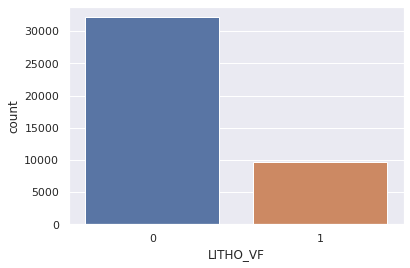

In [ ]:
sns.countplot(x='LITHO_VF', data=df1,orient="h");


Text(0.5, 1.0, 'Distribution de tous les potentiels prédicteurs dans df1')

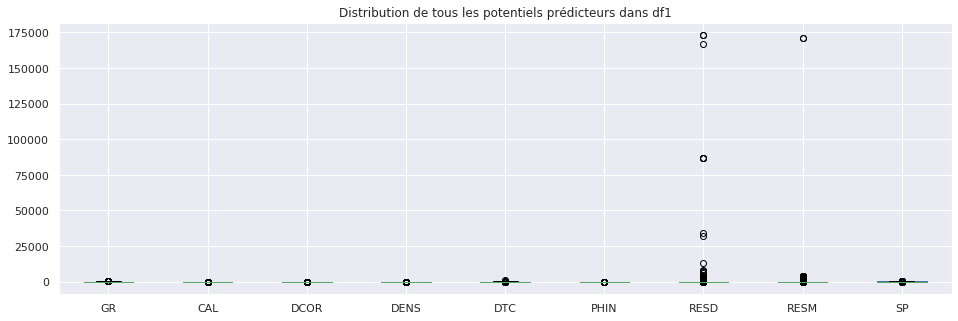

In [ ]:
#Box plot
plt.figure(figsize=(16,5))
df1[['GR','CAL','DCOR','DENS','DTC','PHIN','RESD','RESM','SP']].boxplot() # Nous notons des valeurs négatives pour la variable COR
plt.title("Distribution de tous les potentiels prédicteurs dans df1")

## Commentaire:

Nous constatons une diférence d'échelle au niveau des variables nous allons faire des boxplots pour chaque variable par type de lithologie pour mieux analyser les résultats.

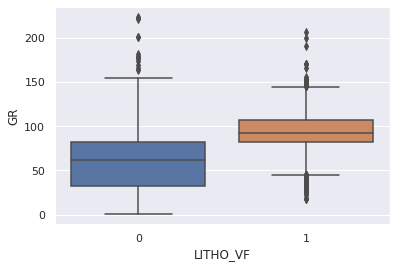

In [ ]:
# Grouped boxplot
sns.boxplot(x='LITHO_VF', y='GR', data=df1) 

### Commentaire: 
La variable Gamma Ray permet de discriminer la lithologie. En effet la distribution des valeurs de Gamma Ray varie nettement selon les lithologies: les valeurs de l'argile (LITHO_VF=1) sont plus élevées et moins dispersées que celles du "non argile".

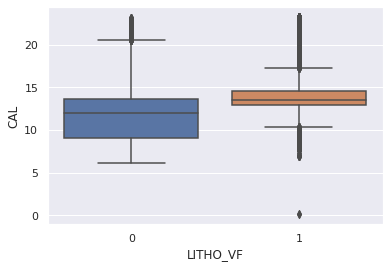

In [ ]:
sns.boxplot(x='LITHO_VF', y='CAL', data=df1) 

### Commentaires:
 Là aussi nous constatons que les valeurs du Caliper de la lithologie argile sont généralement plus élevées que celles des autres lithologies et moins dispersées également.

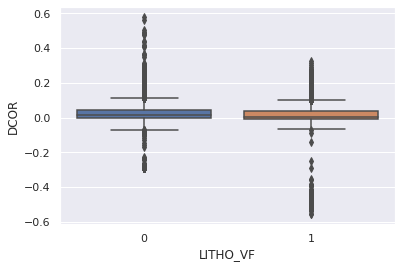

In [ ]:
sns.boxplot(x='LITHO_VF', y='DCOR', data=df1)

### Commentaire :
Les valeurs de la densité corrigée (DCOR) sont très petites. Les distributions des valeurs de DCOR sont presque similaire quelle que soit la lithologie considérée. Nous pouvons aussi affirmer que la variable DCOR n'est pas assez discriminante pour les lithologies
Une autre remarque intéressante: la densité corrigée contient des valeurs négatives. Est-ce normal? Ces valeurs négatives sont-elles des anomalies que l'on doit traiter ? A voir avec l'équipe métier

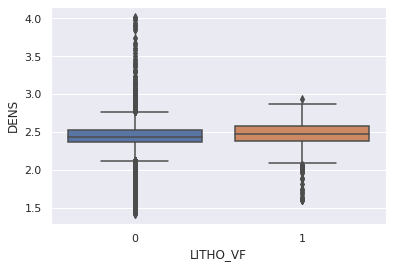

In [ ]:
sns.boxplot(x='LITHO_VF', y='DENS', data=df1) 

### Commentaire:


### Commentaire:
La variable DENS n'est pas apparemment une variable très discriminante pour la lithologie. En effet sa distribution reste presque invariante quelle que soit la lithologie considérée.

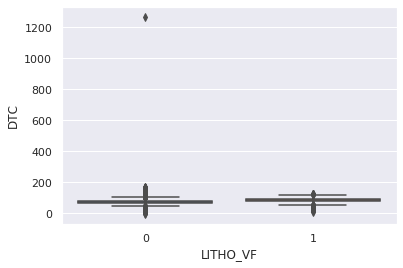

In [ ]:
sns.boxplot(x='LITHO_VF', y='DTC', data=df1) 

### Commentaire:
La vitesse de ralentissement des ondes n'est pas discriminante pour la qualification de la lithologie. En effet la distribution est apparemment la mêême pour l'argile et le non argile.

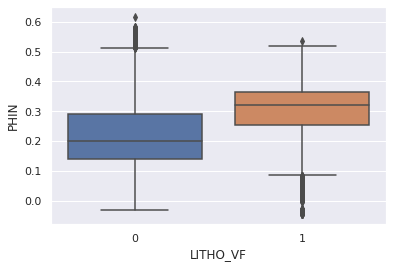

In [ ]:
sns.boxplot(x='LITHO_VF', y='PHIN', data=df1) 

### Commentaire:
Les valeurs de la variable PHIN semblent êêtre plus élevées pour l'argile. En effet pour c'est une variable qui, pour certaines grandeurs, pourrait permettre de distinguer l'argile du non argile

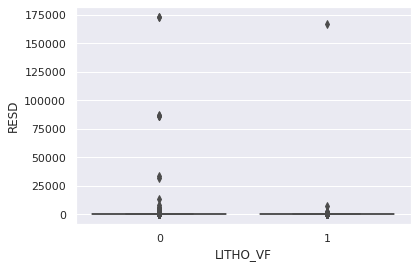

In [ ]:
sns.boxplot(x='LITHO_VF', y='RESD', data=df1) 

### Commentaire:

La distribution des valeurs de la résistivité pour l'argile se condense globalement autour de 0 mais posséde une longue queue de distribution

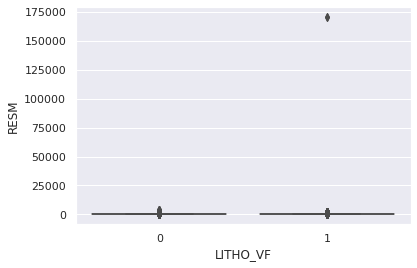

In [ ]:
sns.boxplot(x='LITHO_VF', y='RESM', data=df1) 

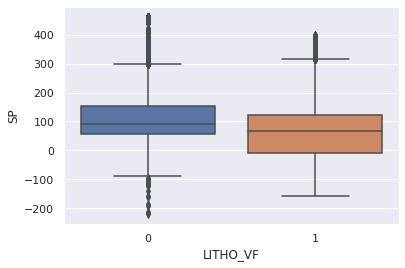

In [ ]:
sns.boxplot(x='LITHO_VF', y='SP', data=df1) 

### Commentaire:

Les valeurs de SP paraissent plus élevées pour le non argile que celles de l'argile. 

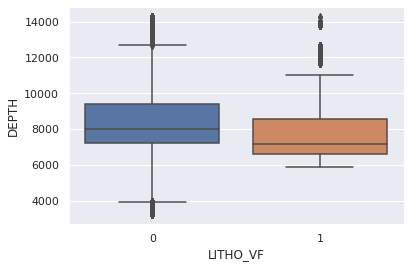

In [ ]:
sns.boxplot(x='LITHO_VF', y='DEPTH', data=df1) 


### Commentaire:
La profondeur de l'argile est en général moins élevée que celle du non argile. Le graphe montre que les argiles sont généralement à des profondeurs moins élevées que celles su non argile. A comparer avec les régles métier selon lesquelles la profondeur n'a pas d'influence sur la lithologie.

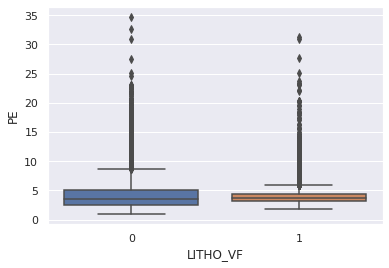

In [ ]:
sns.boxplot(x='LITHO_VF', y='PE', data=df5) 

In [ ]:
# Supression des valeurs négatives de DCOR
#list_table=[df1_drop_NaN,df2_no_SP_PE_drop_NaN,df3_no_SP_drop_NaN,df4_no_PE_drop_NaN]
#for table in list_table:
#    indexNames =table[table['DCOR'] <0 ].index
#    table.drop(indexNames , inplace=True)

In [ ]:
print('df1 contient: ',df1.shape[0],'et ',df1.shape[1] ,'variables qui sont',df1.columns)
print('df2 contient: ',df2.shape[0],'et ',df2.shape[1] ,'variables qui sont',df2.columns)
print('df3 contient: ',df3.shape[0],'et ',df3.shape[1] ,'variables qui sont',df3.columns)
print('df4 contient: ',df4.shape[0],'et ',df4.shape[1] ,'variables qui sont',df4.columns)
print('df5 contient: ',df5.shape[0],'et ',df5.shape[1] ,'variables qui sont',df5.columns)

df1 contient:  41858 et  14 variables qui sont Index(['GR', 'CAL', 'DCOR', 'DENS', 'DTC', 'PHIN', 'RESD', 'RESM', 'SP',
       'DEPTH', 'WELL', 'LITHO', 'LITHO_1', 'LITHO_VF'],
      dtype='object')
df2 contient:  57696 et  12 variables qui sont Index(['GR', 'CAL', 'DCOR', 'DENS', 'PHIN', 'RESD', 'RESM', 'DEPTH', 'WELL',
       'LITHO', 'LITHO_1', 'LITHO_VF'],
      dtype='object')
df3 contient:  62190 et  11 variables qui sont Index(['GR', 'CAL', 'DCOR', 'DENS', 'PHIN', 'RESD', 'DEPTH', 'WELL', 'LITHO',
       'LITHO_1', 'LITHO_VF'],
      dtype='object')
df4 contient:  17212 et  15 variables qui sont Index(['GR', 'CAL', 'DCOR', 'DENS', 'DTC', 'PE', 'PHIN', 'RESD', 'RESM', 'SP',
       'DEPTH', 'WELL', 'LITHO', 'LITHO_1', 'LITHO_VF'],
      dtype='object')
df5 contient:  32952 et  13 variables qui sont Index(['GR', 'CAL', 'DCOR', 'DENS', 'PE', 'PHIN', 'RESD', 'RESM', 'DEPTH',
       'WELL', 'LITHO', 'LITHO_1', 'LITHO_VF'],
      dtype='object')


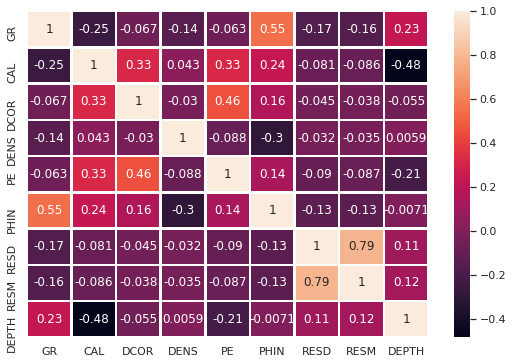

In [ ]:
corr = df5.corr()
f,ax = plt.subplots(figsize=(9,6))
sns.heatmap(corr, annot = True, linewidths=1.5 ,ax=ax)
plt.show()

Les variables PHIN et GR sont corrélées ainsi que RESD et RESM

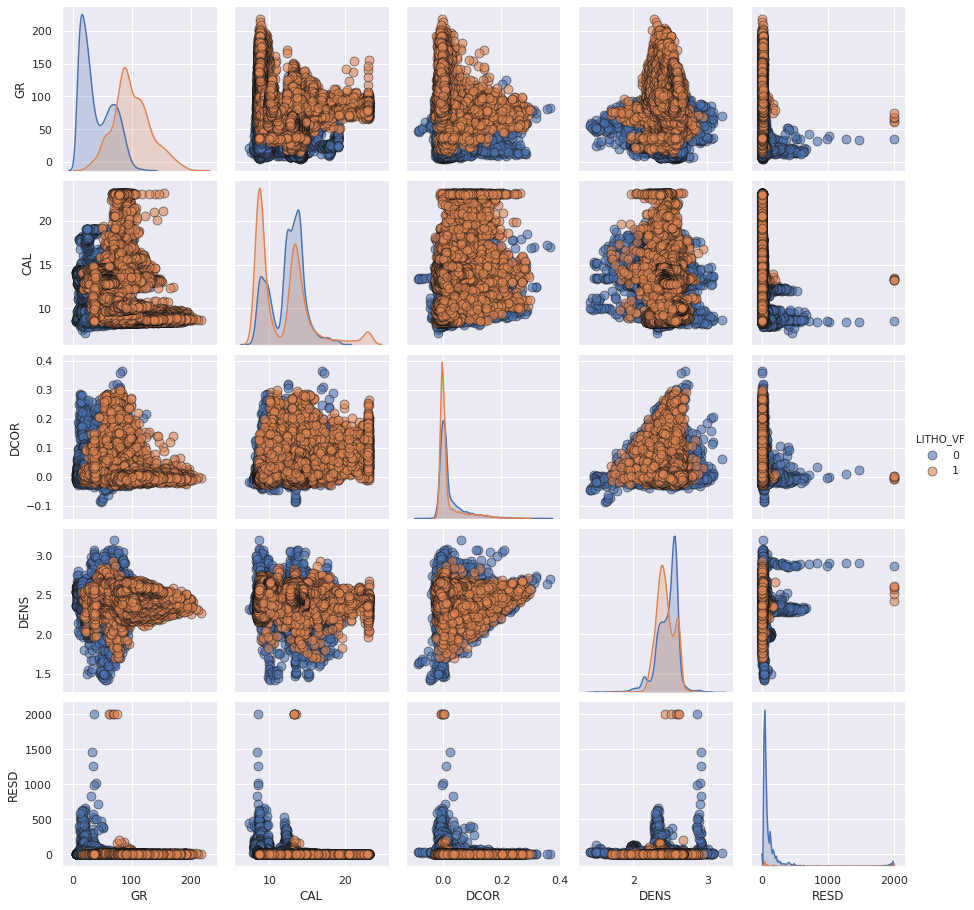

In [ ]:
# Plot colored by LITHO
sns.pairplot(df5,vars = ['GR','CAL','DCOR','DENS','RESD'],#'PHIN','RESM','SP'],
             hue = 'LITHO_VF', diag_kind = 'kde', 
             plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'}
      );# Title 

# Commentaire: 

Nous notons des distributions qui ne permettent pas de discriminer les lithologies de manière significative. Cependant comme vu dans les boxplot la variable Gamma Ray semble être la plus discriminante parmi les variables. Elle est suivie de la variable RESD. NOus notons des distributions bimodales qui n'étaient pas visibles dans les boxplots mais qui témoignent des dispersions constatées pour la variable Gamma Ray (concernant le non argile) et pour la variable (aussi bien pour l'argile que le non argile)


# Machine Learning: 
Plusieurs modéles Machine Learning (KNN,SVM, Random Forest) ont été testés mais dans cette partie nous ne présenterons que les résultats des modéles CART qui sont plus faciles à interpréter par le métiere et qui donnent des niveaux de perfomance très positifs.

### Modéle CART df1

In [ ]:
X_train=df1[['GR', 'CAL', 'DCOR', 'DENS', 'DTC', 'PHIN', 'RESD', 'RESM', 'SP']]
y_train=df1['LITHO_VF']

In [ ]:
list_score=[]
for i in range(1,11):
    dtree = DecisionTreeClassifier(max_depth=i)
    dtree.fit(X_train,y_train)
    scores_dtree = cross_val_score(dtree, X_train, y_train, cv=10, scoring='accuracy')
    list_score.append(scores_dtree.mean())

In [ ]:
list1_score=[]
for i in range(1,11):
    dtree = DecisionTreeClassifier(max_depth=i,criterion='entropy')
    dtree.fit(X_train,y_train)
    scores_dtree = cross_val_score(dtree, X_train, y_train, cv=10, scoring='accuracy')
    list1_score.append(scores_dtree.mean())

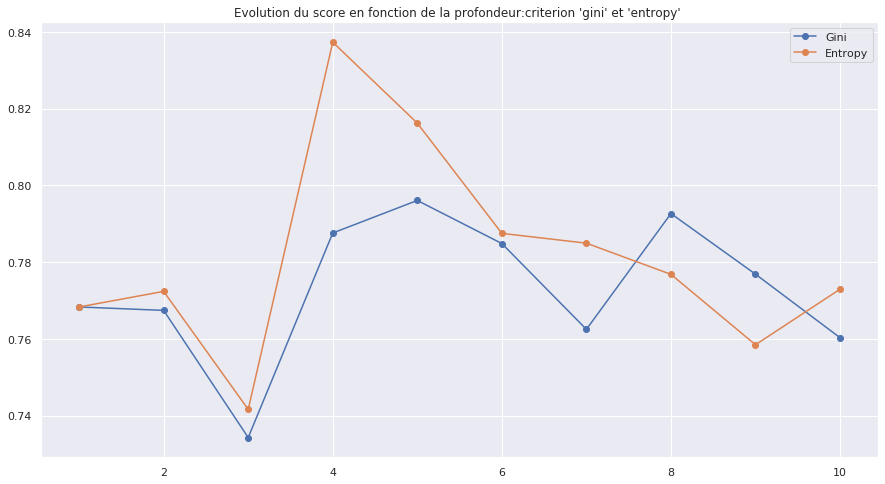

In [ ]:
plt.figure(figsize=(15,8))
plt.subplot()
plt.plot([i for i in range(1,11)],list_score,marker='o',label="Gini")
plt.plot([i for i in range(1,11)],list1_score, marker='o',label="Entropy")
plt.legend()
plt.title("Evolution du score en fonction de la profondeur:criterion 'gini' et 'entropy' ")
plt.show()

In [ ]:
# Au regard du graphe précédent nous choisissons une profondeur de 4 
dtree = DecisionTreeClassifier(max_depth=4)
X_train1, X_test, y_train1, y_test = train_test_split(X_train,y_train, test_size = 0.2, random_state = 1)

In [ ]:
dtree.fit(X_train1,y_train1)
pred_tree=dtree.predict(X_test)
print( 'Accuracy:', accuracy_score(y_test, pred_tree))
#print('F1 score:', f1_score(y_test,pred_tree,pos_label="1"))
#print('Recall:', recall_score(y_test,pred_tree,pos_label="1"))
#print('Precision:', precision_score(y_test,pred_tree,pos_label="1"))
print(classification_report(y_test,pred_tree))

Accuracy: 0.8748208313425705
              precision    recall  f1-score   support

           0       0.87      0.98      0.92      6431
           1       0.88      0.53      0.66      1941

    accuracy                           0.87      8372
   macro avg       0.88      0.76      0.79      8372
weighted avg       0.88      0.87      0.86      8372



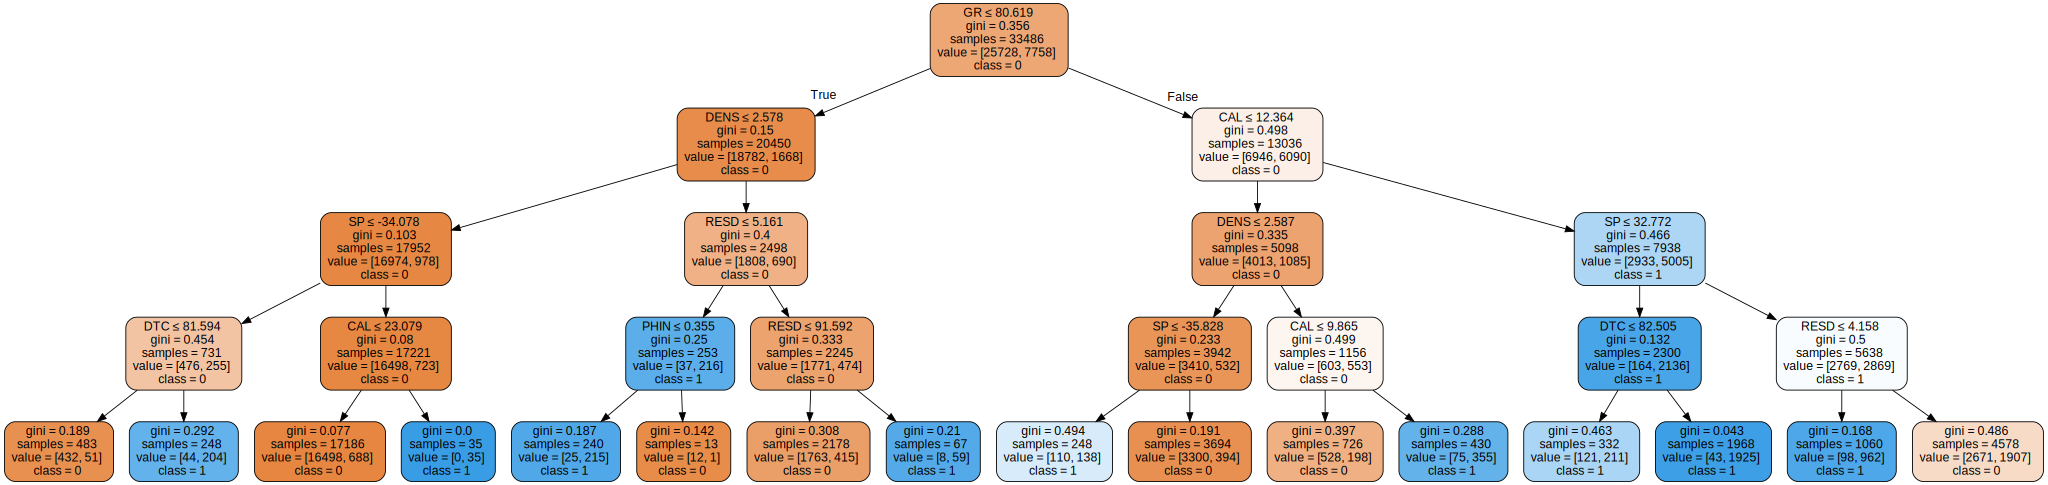

In [ ]:
dot_data = tree.export_graphviz(dtree, out_file=None, 
                 feature_names=['GR', 'CAL', 'DCOR', 'DENS', 'DTC', 'PHIN', 'RESD', 'RESM', 'SP'],  
                      class_names=['0','1'],
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

## Modèle CART: df5

In [ ]:
X_train=df5[['GR', 'CAL', 'DCOR', 'DENS', 'PE', 'PHIN', 'RESD', 'RESM']]
y_train=df5['LITHO_VF']

In [ ]:
list_score=[]
for i in range(1,11):
    dtree = DecisionTreeClassifier(max_depth=i)
    dtree.fit(X_train,y_train)
    scores_dtree = cross_val_score(dtree, X_train, y_train, cv=10, scoring='accuracy')
    list_score.append(scores_dtree.mean())
    

In [ ]:
list1_score=[]
for i in range(1,11):
    dtree = DecisionTreeClassifier(max_depth=i,criterion='entropy')
    dtree.fit(X_train,y_train)
    scores_dtree = cross_val_score(dtree, X_train, y_train, cv=10, scoring='accuracy')
    list1_score.append(scores_dtree.mean())

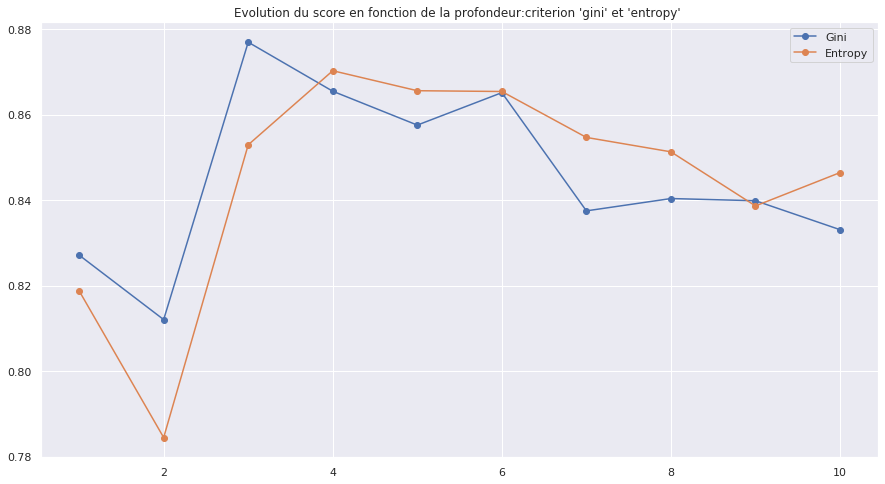

In [ ]:
plt.figure(figsize=(15,8))
plt.subplot()
plt.plot([i for i in range(1,11)],list_score,marker='o',label="Gini")
plt.plot([i for i in range(1,11)],list1_score, marker='o',label="Entropy")
plt.legend()
plt.title("Evolution du score en fonction de la profondeur:criterion 'gini' et 'entropy' ")
plt.show()

In [ ]:
# Au regard du graphe précédent nous choisissons une profondeur de 3 : moins de complexité et plus de performance
dtree = DecisionTreeClassifier(max_depth=3)
X_train1, X_test, y_train1, y_test = train_test_split(X_train,y_train, test_size = 0.2, random_state = 1)
dtree.fit(X_train1,y_train1)
pred_tree=dtree.predict(X_test)
print(accuracy_score(y_test, pred_tree))
print(classification_report(y_test,pred_tree))

0.8950083447124867
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      3456
           1       0.89      0.88      0.89      3135

    accuracy                           0.90      6591
   macro avg       0.89      0.89      0.89      6591
weighted avg       0.89      0.90      0.89      6591



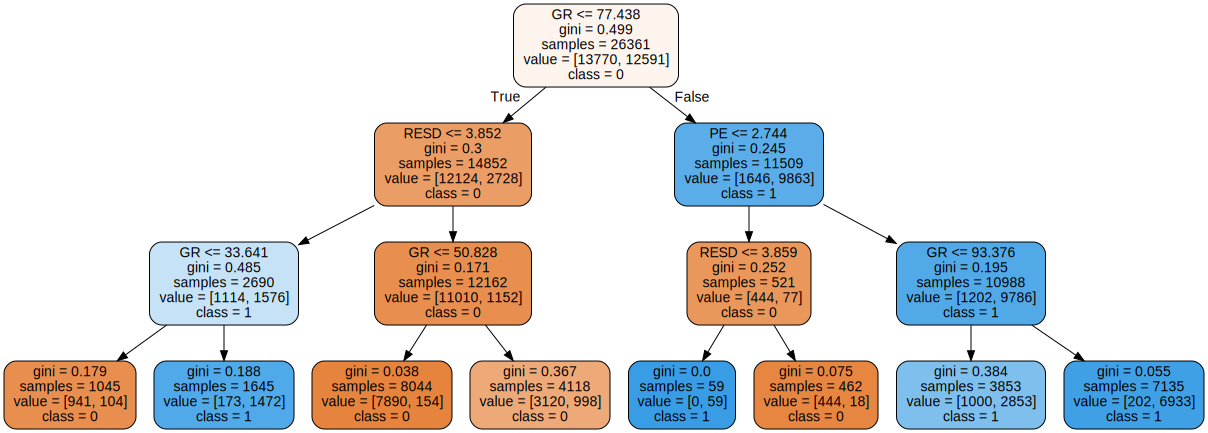

In [ ]:
dot_data = tree.export_graphviz(dtree, out_file=None, 
                 feature_names=['GR', 'CAL', 'DCOR', 'DENS', 'PE', 'PHIN', 'RESD', 'RESM'],  
                      class_names=['0','1'],
                      filled=True, rounded=True,  
                      special_characters=False)  
graph = graphviz.Source(dot_data)  
graph 

## Modèle CART: df2

In [ ]:
X_train=df2[['GR', 'CAL', 'DCOR', 'DENS', 'PHIN', 'RESD', 'RESM']]
y_train=df2['LITHO_VF']

In [ ]:
list_score=[]
for i in range(1,11):
    dtree1 = DecisionTreeClassifier(max_depth=i)
    dtree1.fit(X_train,y_train)
    scores_dtree = cross_val_score(dtree1, X_train, y_train, cv=10, scoring='accuracy')
    list_score.append(scores_dtree.mean())
    

In [ ]:
list1_score=[]
for i in range(1,11):
    dtree1 = DecisionTreeClassifier(max_depth=i,criterion='entropy')
    dtree1.fit(X_train,y_train)
    scores_dtree = cross_val_score(dtree1, X_train, y_train, cv=10, scoring='accuracy')
    list1_score.append(scores_dtree.mean())

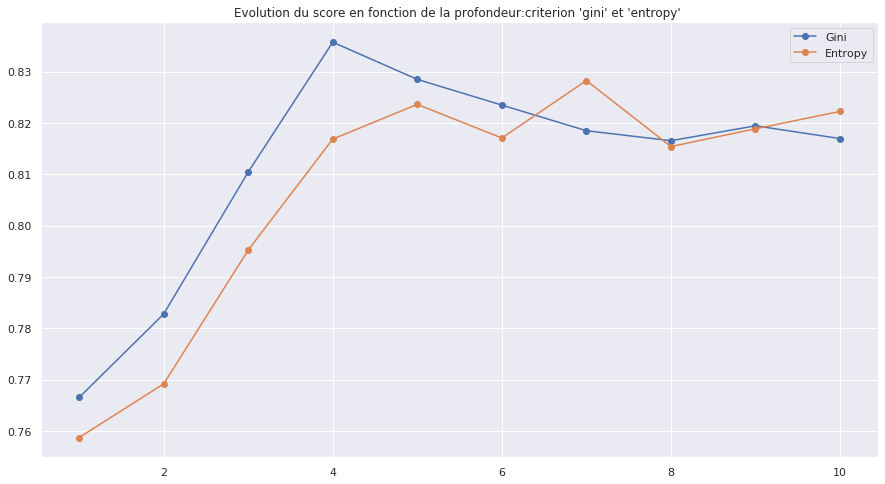

In [ ]:
plt.figure(figsize=(15,8))
plt.subplot()
plt.plot([i for i in range(1,11)],list_score,marker='o',label="Gini")
plt.plot([i for i in range(1,11)],list1_score, marker='o',label="Entropy")
plt.legend()
plt.title("Evolution du score en fonction de la profondeur:criterion 'gini' et 'entropy' ")
plt.show()

In [ ]:
# Au regard du graphe précédent nous choisissons une profondeur de 4 : moins de complexité et plus de performance
dtree1 = DecisionTreeClassifier(max_depth=4)
X_train1, X_test, y_train1, y_test = train_test_split(X_train,y_train, test_size = 0.2, random_state = 1)
dtree1.fit(X_train1,y_train1)
pred_tree=dtree1.predict(X_test)
print(accuracy_score(y_test, pred_tree))
print(classification_report(y_test,pred_tree))

0.8762564991334488
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      7824
           1       0.89      0.70      0.79      3716

    accuracy                           0.88     11540
   macro avg       0.88      0.83      0.85     11540
weighted avg       0.88      0.88      0.87     11540



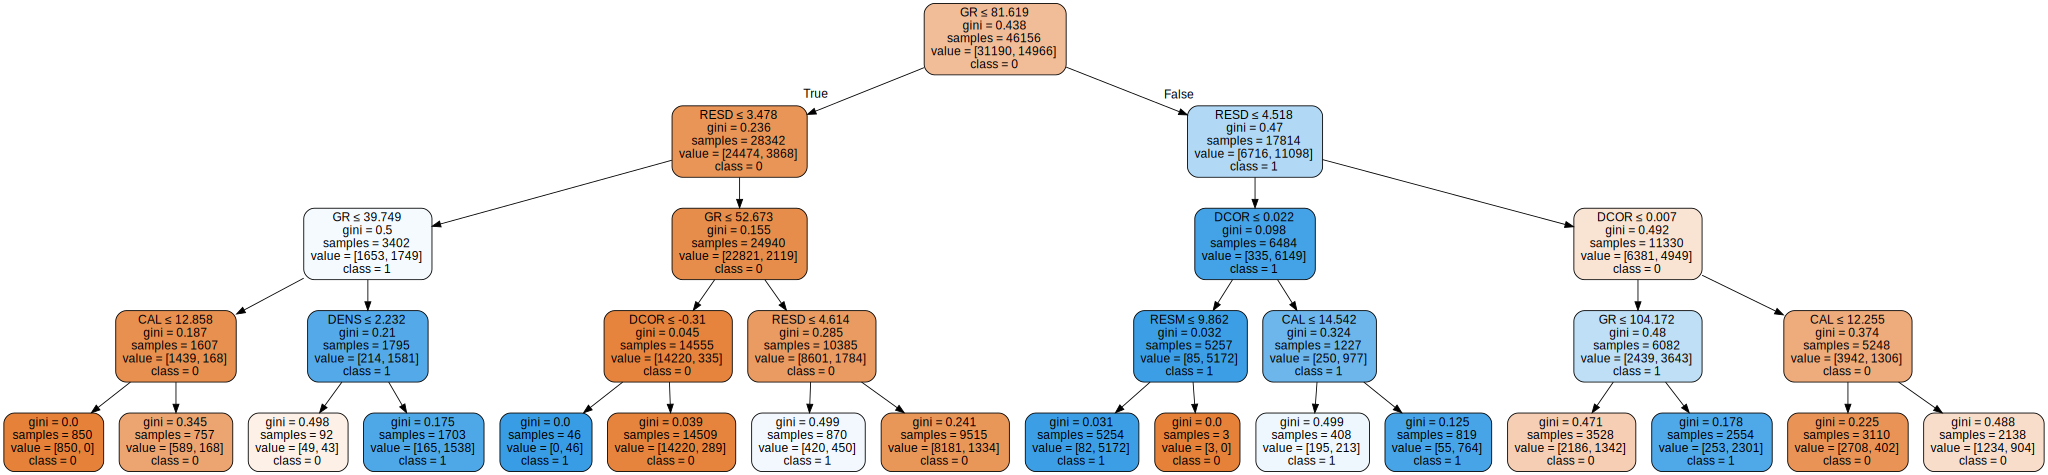

In [ ]:
dot_data = tree.export_graphviz(dtree1, out_file=None, 
                 feature_names=['GR', 'CAL', 'DCOR', 'DENS', 'PHIN', 'RESD', 'RESM'],
                      class_names=['0','1'],
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

## Modèle CART: df3_

In [ ]:
X_train=df3[['GR', 'CAL', 'DCOR', 'DENS', 'PHIN', 'RESD']]
y_train=df3['LITHO_VF']

In [ ]:
list_score=[]
for i in range(1,11):
    dtree2 = DecisionTreeClassifier(max_depth=i)
    dtree2.fit(X_train,y_train)
    scores_dtree = cross_val_score(dtree2, X_train, y_train, cv=10, scoring='accuracy')
    list_score.append(scores_dtree.mean())
    

In [ ]:
list1_score=[]
for i in range(1,11):
    dtree2 = DecisionTreeClassifier(max_depth=i,criterion='entropy')
    dtree2.fit(X_train,y_train)
    scores_dtree = cross_val_score(dtree2, X_train, y_train, cv=10, scoring='accuracy')
    list1_score.append(scores_dtree.mean())

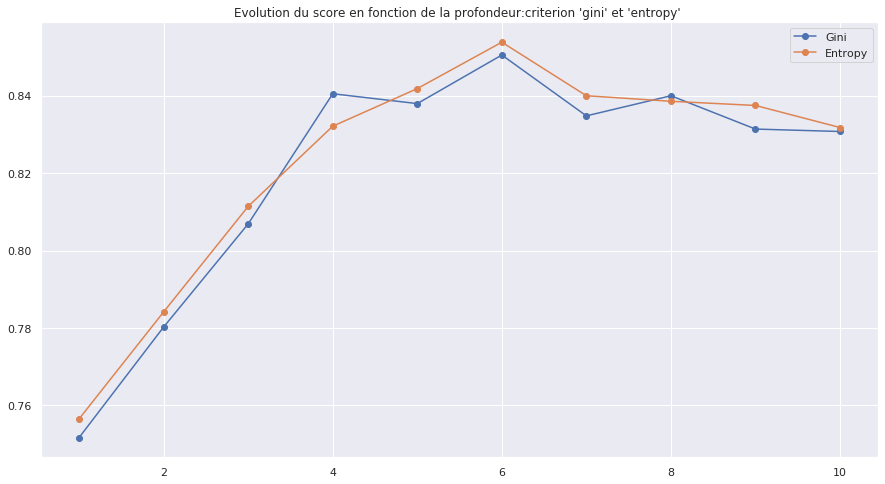

In [ ]:
plt.figure(figsize=(15,8))
plt.subplot()
plt.plot([i for i in range(1,11)],list_score,marker='o',label="Gini")
plt.plot([i for i in range(1,11)],list1_score, marker='o',label="Entropy")
plt.legend()
plt.title("Evolution du score en fonction de la profondeur:criterion 'gini' et 'entropy' ")
plt.show()

In [ ]:
# Au regard du graphe précédent nous choisissons une profondeur de 6
dtree2 = DecisionTreeClassifier(max_depth=6)
X_train1, X_test, y_train1, y_test = train_test_split(X_train,y_train, test_size = 0.2, random_state = 1)
dtree2.fit(X_train1,y_train1)
pred_tree=dtree2.predict(X_test)
print(accuracy_score(y_test, pred_tree))
print(classification_report(y_test,pred_tree))

0.8942756070107735
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      8370
           1       0.90      0.76      0.82      4068

    accuracy                           0.89     12438
   macro avg       0.90      0.86      0.87     12438
weighted avg       0.90      0.89      0.89     12438



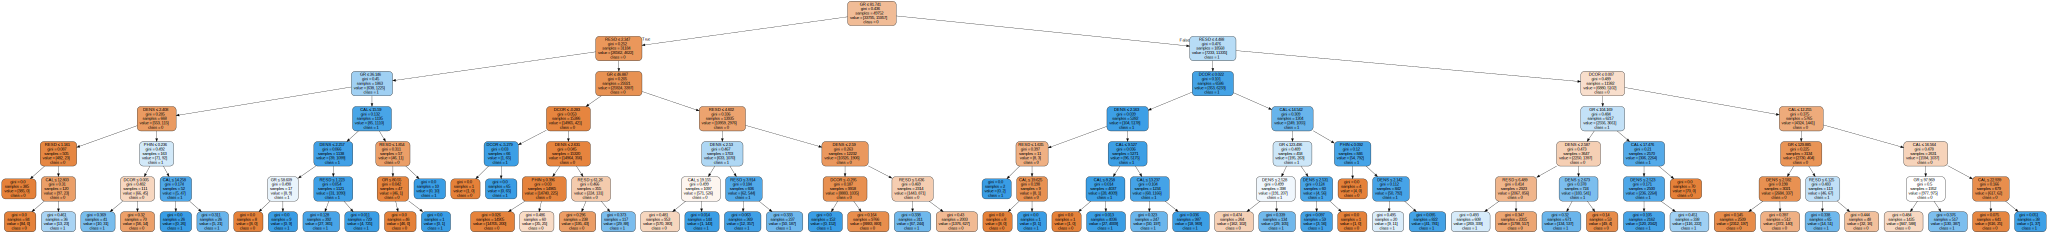

In [ ]:
dot_data = tree.export_graphviz(dtree2, out_file=None, 
                 feature_names=['GR', 'CAL', 'DCOR', 'DENS', 'PHIN', 'RESD'],  
                      class_names=['0','1'],
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

# Modèle avec df4

In [ ]:
X_train=df4[['GR', 'CAL', 'DCOR', 'DENS', 'DTC', 'PE', 'PHIN', 'RESD', 'RESM', 'SP']]
y_train=df4['LITHO_VF']

In [ ]:
list_score=[]
for i in range(1,11):
    dtree2 = DecisionTreeClassifier(max_depth=i)
    dtree2.fit(X_train,y_train)
    scores_dtree = cross_val_score(dtree2, X_train, y_train, cv=10, scoring='accuracy')
    list_score.append(scores_dtree.mean())
    

In [ ]:
list1_score=[]
for i in range(1,11):
    dtree2 = DecisionTreeClassifier(max_depth=i,criterion='entropy')
    dtree2.fit(X_train,y_train)
    scores_dtree = cross_val_score(dtree2, X_train, y_train, cv=10, scoring='accuracy')
    list1_score.append(scores_dtree.mean())

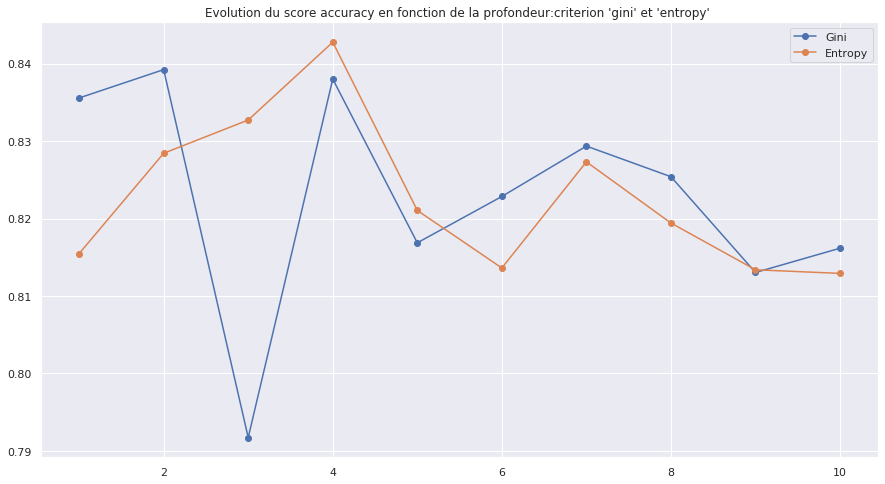

In [ ]:
plt.figure(figsize=(15,8))
plt.subplot()
plt.plot([i for i in range(1,11)],list_score,marker='o',label="Gini")
plt.plot([i for i in range(1,11)],list1_score, marker='o',label="Entropy")
plt.legend()
plt.title("Evolution du score accuracy en fonction de la profondeur:criterion 'gini' et 'entropy' ")
plt.show()

In [ ]:
# Au regard du graphe précédent nous choisissons une profondeur de 4 : moins de complexité et plus de performance
dtree2 = DecisionTreeClassifier(max_depth=4)
X_train1, X_test, y_train1, y_test = train_test_split(X_train,y_train, test_size = 0.2, random_state = 1)
dtree2.fit(X_train1,y_train1)
pred_tree=dtree2.predict(X_test)
print(accuracy_score(y_test, pred_tree))
print(classification_report(y_test,pred_tree))

0.8939878013360442
              precision    recall  f1-score   support

           0       0.90      0.93      0.91      2073
           1       0.89      0.83      0.86      1370

    accuracy                           0.89      3443
   macro avg       0.89      0.88      0.89      3443
weighted avg       0.89      0.89      0.89      3443



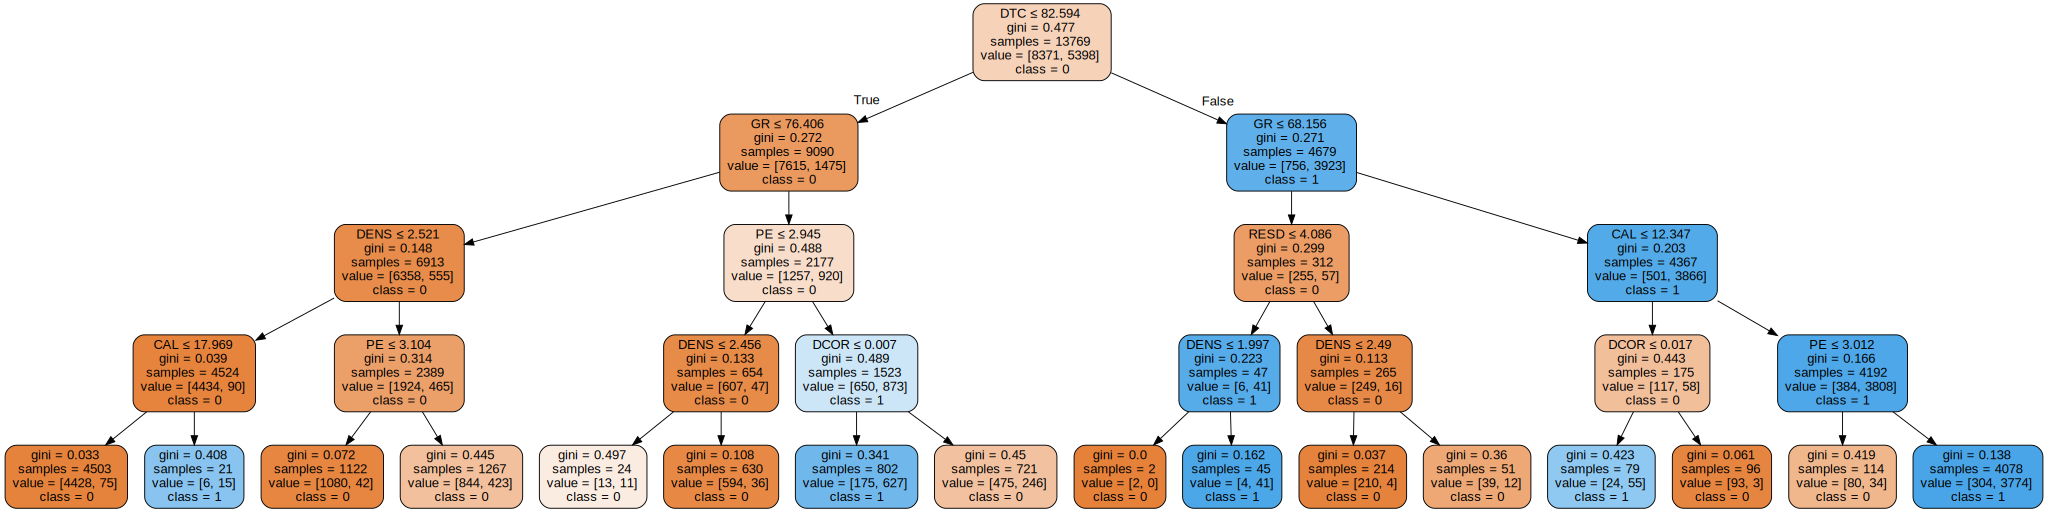

In [ ]:
dot_data = tree.export_graphviz(dtree2, out_file=None, 
                 feature_names=['GR', 'CAL', 'DCOR', 'DENS', 'DTC', 'PE', 'PHIN', 'RESD', 'RESM', 'SP'],  
                      class_names=['0','1'],
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 